In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['figure.figsize'] = (20,6)
import warnings
warnings.simplefilter(action='ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
import statsmodels.api as sm
from pmdarima.arima import auto_arima

In [2]:
with open("data/TG_STAID002759.txt", "r") as f:
    l=f.readlines()

In [3]:
for i in range(10,14):
    print(l[i])

01-06 SOUID: Source identifier

08-15 DATE : Date YYYYMMDD

17-21 TG   : mean temperature in 0.1 &#176;C

23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')



In [10]:
df = pd.read_csv('data/TG_STAID002759.txt', skiprows=19)
df.columns = df.columns.str.strip()

In [11]:
df['DATE']=df['DATE'].astype(str)

In [12]:
df['DATE']=pd.to_datetime(df['DATE'])


In [13]:
df=df.set_index('DATE')

### Exprlore the data

In [14]:
df[df['Q_TG']==9].value_counts() # -> exclude this period 

SOUID   TG     Q_TG
127488  -9999  9       195
dtype: int64

In [15]:
#converting to C
df['TG']=df['TG']*0.1

In [16]:
df[df.index.year==2021].mean()   # -> exclude 2021 

SOUID    111448.000000
TG            5.713245
Q_TG          0.000000
dtype: float64

In [17]:
#select 1970-2020 as our data
df_new=df.loc['1970-01-01':'2020-12-31'].drop(['Q_TG','SOUID'],axis=1)

In [18]:
df_feat=df.loc['2021-01-01':].drop(['Q_TG','SOUID'],axis=1)
df_feat.to_pickle('df_feat.pkl') #  saving fro forcast

## Selecting train and test

In [19]:
df_train=df_new.loc['1970-01-01':'2015-12-31']  #50 years

In [20]:
df_test=df_new.loc['2016-01-01':'2020-12-31']  #the last 5 years

<AxesSubplot:xlabel='DATE'>

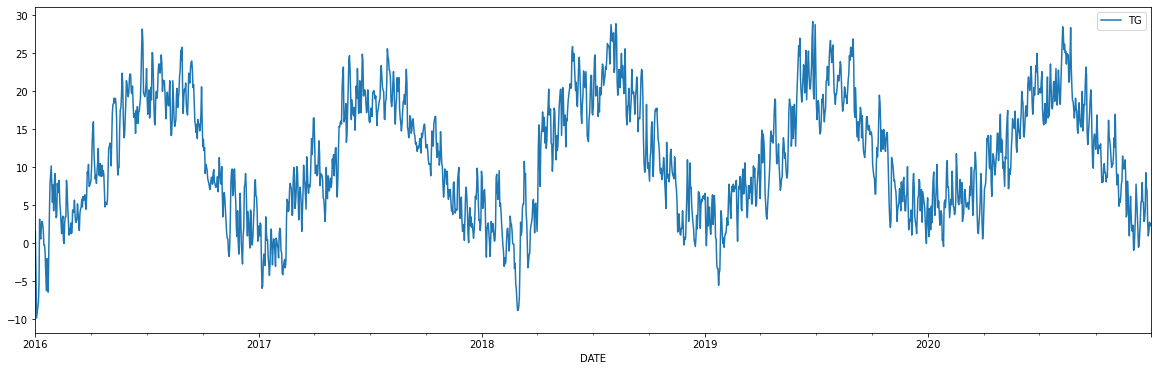

In [14]:
df_test.plot()

In [15]:
df_test.to_pickle('df_test.pkl')

<AxesSubplot:xlabel='DATE'>

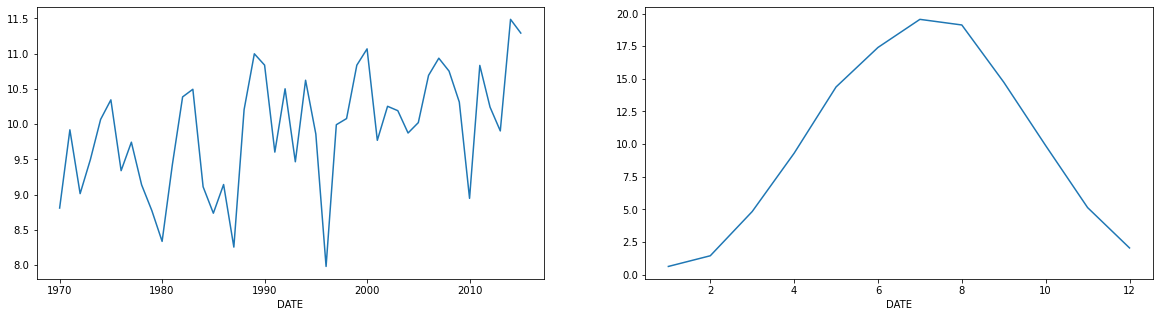

In [16]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
df_train.groupby(df_train.index.year)['TG'].mean().plot(ax=ax1)
df_train.groupby(df_train.index.month)['TG'].mean().plot(ax=ax2)

<AxesSubplot:xlabel='TG', ylabel='Density'>

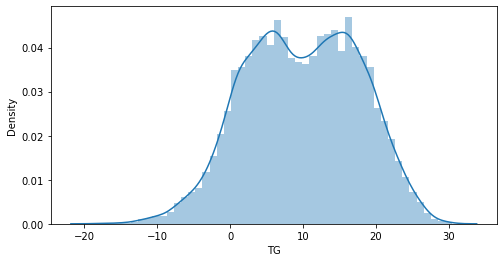

In [30]:
plt.figure(figsize=(8,4))
sns.distplot(df_train["TG"])

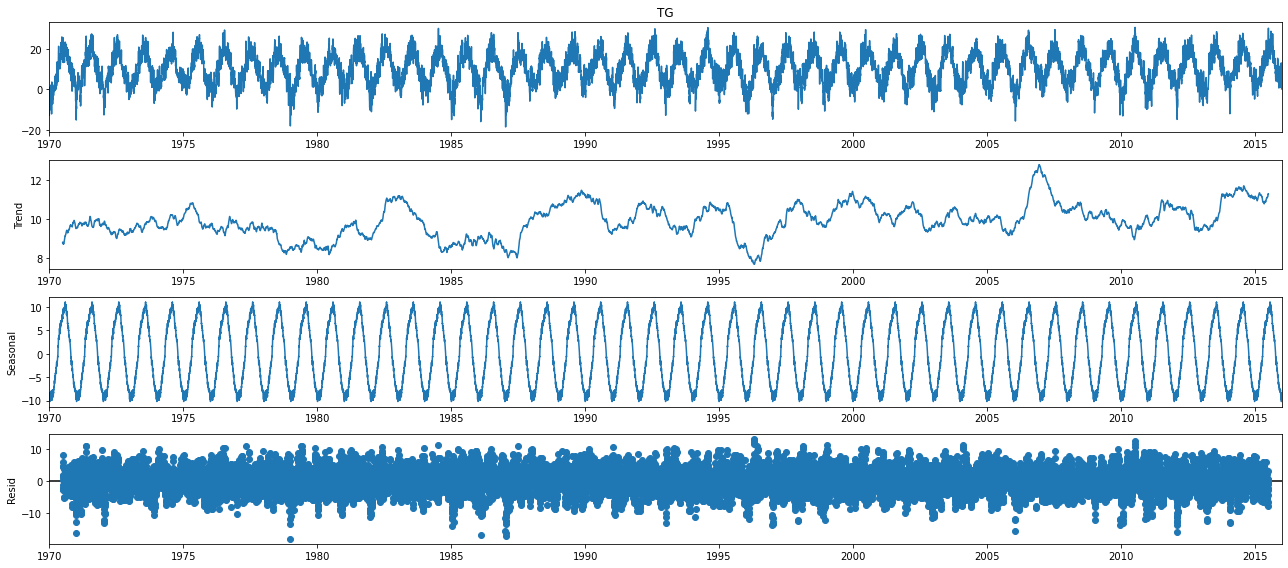

In [18]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_train['TG'], model='additive',period=365)
fig = decomposition.plot()
plt.show()

## Dickey–Fuller test

In [21]:
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
perform_dickey_fuller_test(df_train['TG'])

ADF Statistic: -8.878670
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can see that our statistic value of -8.887960 is less than the value of -3.430739767618574 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.(why? the result should show not stationary data..)

Let's check the mean and variance of the first and the last three months 

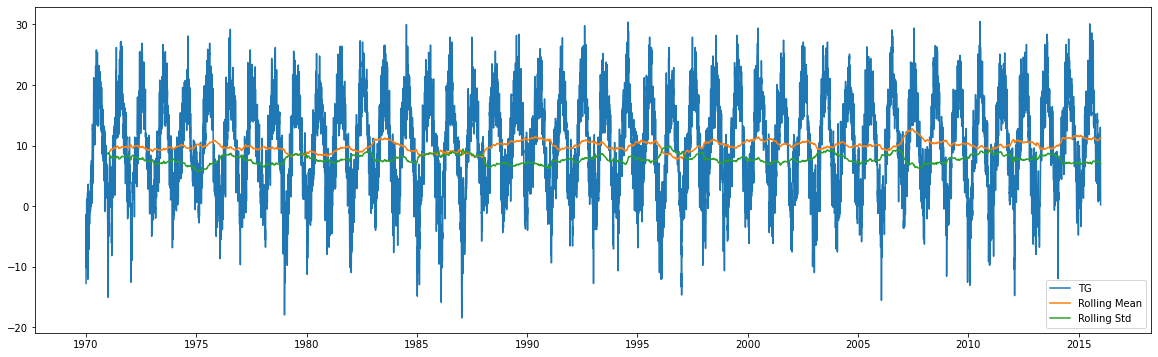

In [29]:
rolling_mean = df_train['TG'].rolling(365).mean()
rolling_std = df_train['TG'].rolling(365).std()
plt.plot(df_train['TG'],label='TG')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label = 'Rolling Std')
plt.legend()

In [21]:
X = df_train['TG']
X1, X2 = X['1970-01-01':'1970-03-31'], X['2015-01-01':'2015-03-31']
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()

print(f'mean1 = {mean1}, mean2 = {mean2}')
print(f'variance1 = {var1}, variance2 = {var2}')

mean1 = -1.2944444444444452, mean2 = 3.9599999999999986
variance1 = 16.895586766541822, variance2 = 9.335910112359553


Based on the above analysis, we conclude that the data is not stationary

## Modeling trend and seasonality and extracting remainder

In [22]:
#Model the trend
# create timestep variable to model the trend using LR

df_train['timestep'] = list(range(len(df_train)))

In [23]:
#Model the seasonality
# make dummy columns for months
seasonal_dummies = pd.get_dummies(df_train.index.month_name(), drop_first=True).set_index(df_train.index)

In [24]:
df_train = df_train.join(seasonal_dummies)
df_train.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,,
1970-01-01,-12.8,0,0,0,0,1,0,0,0,0,0,0,0
1970-01-02,-4.9,1,0,0,0,1,0,0,0,0,0,0,0
1970-01-03,-1.4,2,0,0,0,1,0,0,0,0,0,0,0
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0


In [25]:
# model seaonality and trend
m_seas_trend = LinearRegression()
# set timestep as X and map to y

y = df_train['TG']
X=df_train.drop(columns=['TG'])
m_seas_trend.fit(X, y)
df_train['seasonal_trend'] = m_seas_trend.predict(X)

<AxesSubplot:xlabel='DATE'>

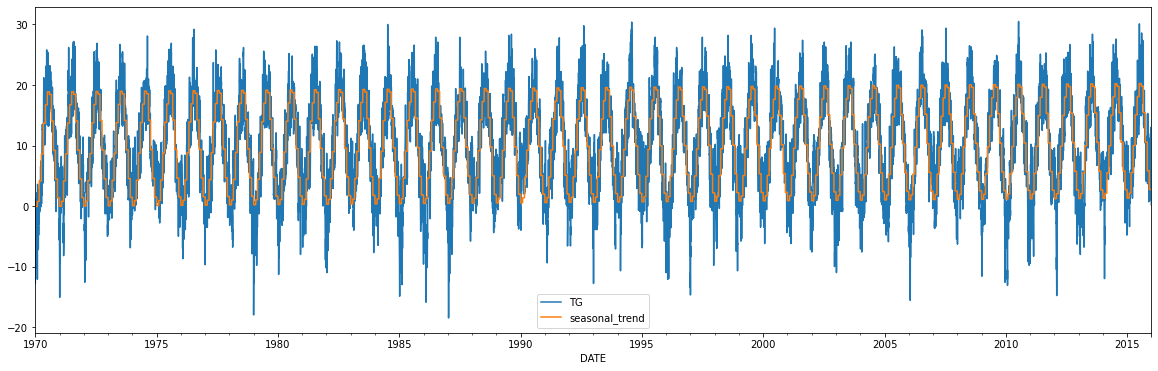

In [26]:
#Plot the original data and the trend with seasonality
df_train[['TG', 'seasonal_trend']].plot()


In [27]:
#Extract the remainder
df_train['remainder']=df_train['TG']-df_train['seasonal_trend']


<AxesSubplot:xlabel='DATE'>

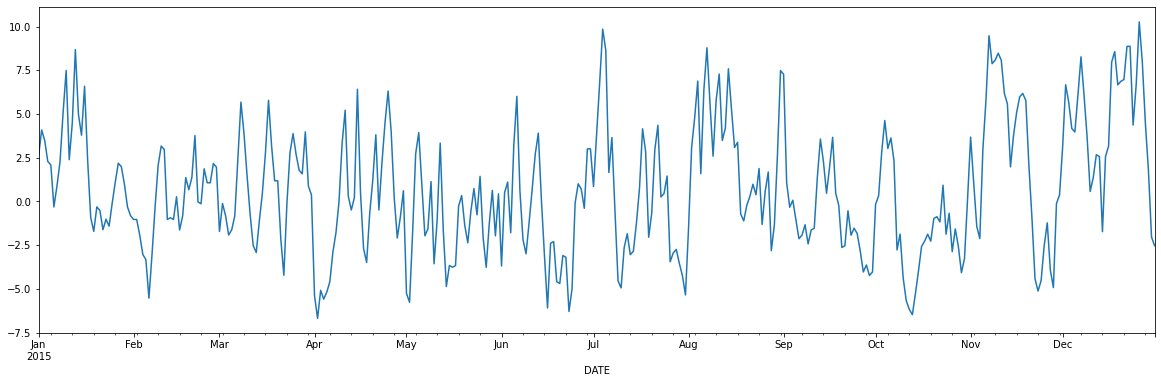

In [28]:
df_train[df_train.index.year==2015]['remainder'].plot()

In [31]:
perform_dickey_fuller_test(df_train['remainder'])  #the remainder is stationary

ADF Statistic: -38.126669
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## AR or ARIMA model?

One tool to find out which model to use how many lags we should include into our Autoregressive Model is to plot the Autocorrelation and the Partial Autocorrelation between different lags of the remainder

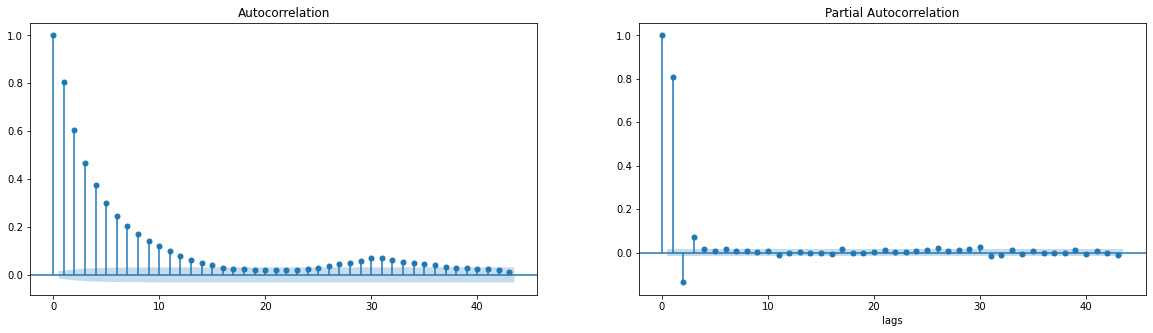

In [29]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20, 5)
plot_acf(df_train['remainder'],ax=ax1)
plot_pacf(df_train['remainder'],ax=ax2)

plt.xlabel('lags');

ACF-Plot is clearly showing an exponential and slow decay.

PACF-Plot also shows exponential decay, but not a slow one. And there is a drop after a certain lag. 

We might conclude that the data is best modelled by an AR(p) process with  p = 3 lags.
However, I decide to also run ARIMA and compare results.

**Box-Jenkins-Methodology:**

This methodology makes a statement about how to choose lags.

We will choose all lags until the first sharp drop in values. In this case we will have 3 lags. This is the point after which we know the correlation dropped significantly. 

## confirm with ar_select_order

In [32]:
selected_order = ar_select_order(df_train['remainder'], maxlag = 12)

In [33]:
selected_order.ar_lags

array([1, 2, 3])

In [35]:
#saving remainder
df_train.to_pickle('df_train.pkl')

In [36]:
df_train=pd.read_pickle('df_train.pkl')

## Autoregressive Model - AR(3) on Train data

Create  time-lagged input features

In [34]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)


In [35]:
df_train.dropna(inplace=True)
df_train.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
1970-01-04,-4.4,3,0,0,0,1,0,0,0,0,0,0,0,-0.068299,-4.331701,-1.331617,-4.831533,-12.731449
1970-01-05,-3.0,4,0,0,0,1,0,0,0,0,0,0,0,-0.068215,-2.931785,-4.331701,-1.331617,-4.831533
1970-01-06,-4.7,5,0,0,0,1,0,0,0,0,0,0,0,-0.068131,-4.631869,-2.931785,-4.331701,-1.331617
1970-01-07,-7.1,6,0,0,0,1,0,0,0,0,0,0,0,-0.068047,-7.031953,-4.631869,-2.931785,-4.331701
1970-01-08,-10.2,7,0,0,0,1,0,0,0,0,0,0,0,-0.067963,-10.132037,-7.031953,-4.631869,-2.931785


<AxesSubplot:>

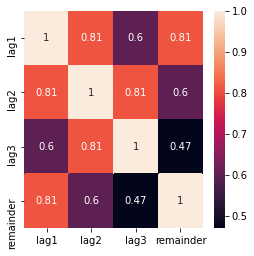

In [36]:
plt.figure(figsize=(4,4))
sns.heatmap(round(df_train[['lag1','lag2','lag3', 'remainder']].corr(), 2), annot=True)


<AxesSubplot:xlabel='lag3', ylabel='remainder'>

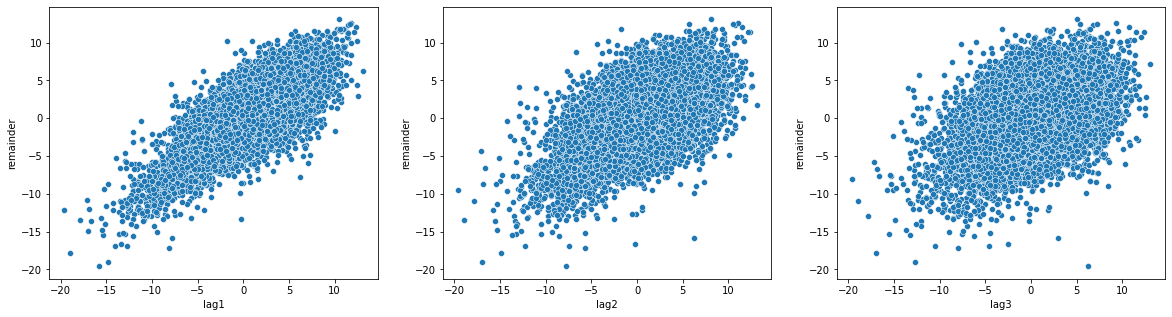

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)

sns.scatterplot(x='lag1', y='remainder', data=df_train,ax=ax1)
sns.scatterplot(x='lag2', y='remainder', data=df_train,ax=ax2)
sns.scatterplot(x='lag3', y='remainder', data=df_train,ax=ax3)

<AxesSubplot:xlabel='DATE'>

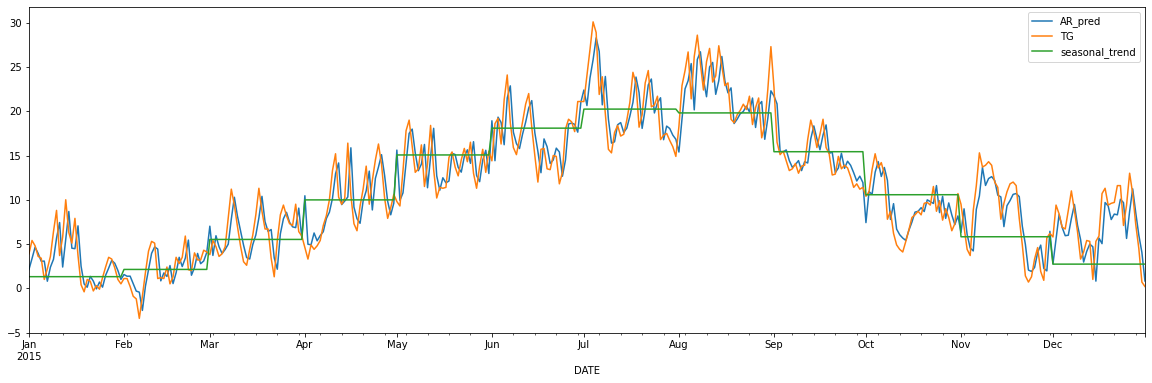

In [41]:
# Define X and y
X = df_train.drop(columns=['TG', 'seasonal_trend', 'remainder'])
y = df_train['TG']

# Train the model
m_AR= LinearRegression()
m_AR.fit(X, y)

# Create a new predictions column for the AR_prediction
df_train['AR_pred'] = m_AR.predict(X)

df_train[df_train.index.year==2015][['AR_pred','TG','seasonal_trend']].plot()

### Cross-validation 

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.
Cross-validation for time series:

- Dividing training data into subsets (folds) - order respective to time is maintained
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and thesecond fold to evaluate the third fold
- ...

In [42]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

time_cv = ts_split.split(X, y) # this is a python generator
    

In [43]:
# cross validate model and read scores 
time_cv = ts_split.split(X, y)

estimator = LinearRegression()

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.9114446  0.90312729 0.90592572 0.92236022 0.92165419]
0.9129024040278318


## Autoregressive Model - AR(3) on Test data

In [53]:
df_test=pd.read_pickle('df_test.pkl')

In [54]:
# add time step

last_train_timestep = df_train['timestep'].max() 

df_test['timestep'] = list(range(last_train_timestep + 1, len(df_test) + last_train_timestep + 1))

In [55]:
# Add encoded month
# we have to apply the same steps we applied to our train data

seasonal_dummies = pd.get_dummies(df_test.index.month_name(), drop_first=True).set_index(df_test.index)

In [56]:
df_test = df_test.join(seasonal_dummies)


In [57]:
# Add trend and seasonality prediction
X_test = df_test.drop('TG', axis=1)


In [58]:
#make predictions uning  m_seas_trend model
df_test['seasonal_trend'] = m_seas_trend.predict(X_test)

<AxesSubplot:xlabel='DATE'>

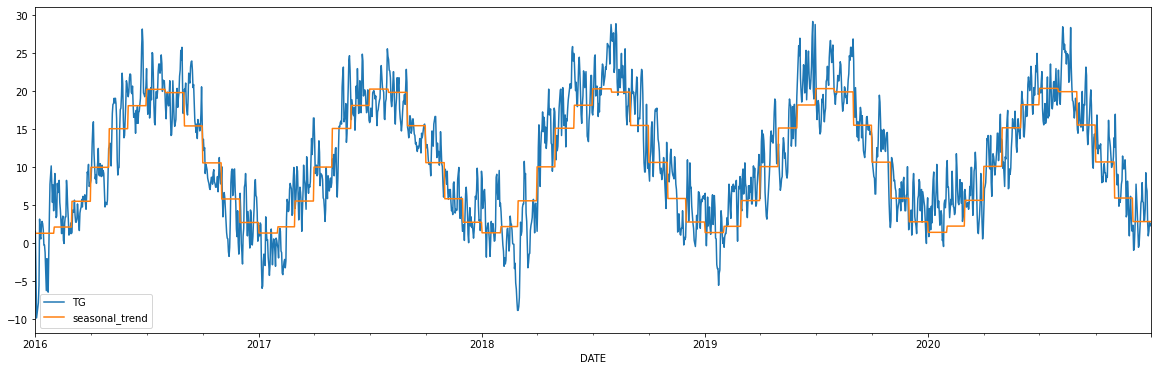

In [59]:
# plot
df_test[['TG', 'seasonal_trend']].plot()

In [60]:
#Calculate remainder and add lags
df_test['remainder'] = df_test['TG'] - df_test['seasonal_trend']

# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)

df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2016-01-01,1.6,16801,0,0,0,1,0,0,0,0,0,0,0,1.341262,0.258738,NaN,NaN,NaN
2016-01-02,-3.6,16802,0,0,0,1,0,0,0,0,0,0,0,1.341346,-4.941346,0.258738,NaN,NaN
2016-01-03,-9.8,16803,0,0,0,1,0,0,0,0,0,0,0,1.341430,-11.141430,-4.941346,0.258738,NaN
2016-01-04,-9.1,16804,0,0,0,1,0,0,0,0,0,0,0,1.341513,-10.441513,-11.141430,-4.941346,0.258738
2016-01-05,-8.4,16805,0,0,0,1,0,0,0,0,0,0,0,1.341597,-9.741597,-10.441513,-11.141430,-4.941346


In [61]:
# fill NaN

df_test.loc['2016-01-01', 'lag1'] = df_train.loc['2015-12-31', 'remainder']
df_test.loc['2016-01-02', 'lag2'] = df_train.loc['2015-12-31', 'remainder']
df_test.loc['2016-01-03', 'lag3'] = df_train.loc['2015-12-31', 'remainder']

df_test.loc['2016-01-01', 'lag2'] = df_train.loc['2015-12-31', 'lag1']
df_test.loc['2016-01-02', 'lag3'] = df_train.loc['2015-12-31', 'lag1']

df_test.loc['2016-01-01', 'lag3'] = df_train.loc['2015-12-31', 'lag2']
df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,
2016-01-01,1.6,16801,0,0,0,1,0,0,0,0,0,0,0,1.341262,0.258738,-2.530452,-2.030368,1.769716
2016-01-02,-3.6,16802,0,0,0,1,0,0,0,0,0,0,0,1.341346,-4.941346,0.258738,-2.530452,-2.030368
2016-01-03,-9.8,16803,0,0,0,1,0,0,0,0,0,0,0,1.341430,-11.141430,-4.941346,0.258738,-2.530452
2016-01-04,-9.1,16804,0,0,0,1,0,0,0,0,0,0,0,1.341513,-10.441513,-11.141430,-4.941346,0.258738
2016-01-05,-8.4,16805,0,0,0,1,0,0,0,0,0,0,0,1.341597,-9.741597,-10.441513,-11.141430,-4.941346


In [62]:
# make AG model predictions

X_test = df_test.drop(['TG', 'seasonal_trend', 'remainder'], axis=1)
# Create the predictions
df_test['AR_pred'] = m_AR.predict(X_test)

df_test.head()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3,AR_pred
DATE,,,,,,,,,,,,,,,,,,,
2016-01-01,1.6,16801,0,0,0,1,0,0,0,0,0,0,0,1.341262,0.258738,-2.530452,-2.030368,1.769716,-0.429052
2016-01-02,-3.6,16802,0,0,0,1,0,0,0,0,0,0,0,1.341346,-4.941346,0.258738,-2.530452,-2.030368,1.989414
2016-01-03,-9.8,16803,0,0,0,1,0,0,0,0,0,0,0,1.341430,-11.141430,-4.941346,0.258738,-2.530452,-3.447328
2016-01-04,-9.1,16804,0,0,0,1,0,0,0,0,0,0,0,1.341513,-10.441513,-11.141430,-4.941346,0.258738,-7.940261
2016-01-05,-8.4,16805,0,0,0,1,0,0,0,0,0,0,0,1.341597,-9.741597,-10.441513,-11.141430,-4.941346,-6.397045


<AxesSubplot:xlabel='DATE'>

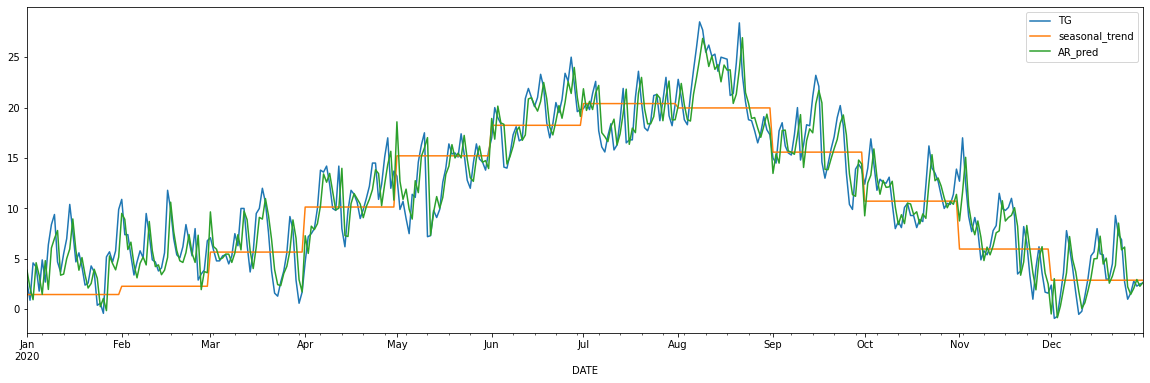

In [63]:
df_test[df_test.index.year==2020][['TG', 'seasonal_trend','AR_pred']].plot()

In [64]:
df_train=df_train.dropna()

### Evaluation

In [65]:
# let's check R squared score

print("R2 score Trend+Seasonality Model :",r2_score(df_test['TG'], df_test['seasonal_trend']))

print("R2 score Autoregressive Model    :",r2_score(df_test['TG'], df_test['AR_pred']))


R2 score Trend+Seasonality Model : 0.7725310108865036
R2 score Autoregressive Model    : 0.9188415604091761


In [66]:
print("MSE Trend+Seasonality Model :", mean_squared_error(df_test['TG'], df_test['seasonal_trend']))
print("MSE Autoregressive Model    :", mean_squared_error(df_test['TG'], df_test['AR_pred']))

MSE Trend+Seasonality Model : 13.359219584347226
MSE Autoregressive Model    : 4.76642297414802


## Retrain the model on the whole data and Generate short term predictions

In [67]:
# join test and train data together

df_combined = df_train.append(df_test)
df_combined.tail()

,TG,timestep,August,December,February,January,July,June,March,May,November,October,September,seasonal_trend,remainder,lag1,lag2,lag3,AR_pred
DATE,,,,,,,,,,,,,,,,,,,
2020-12-27,1.6,18623,0,1,0,0,0,0,0,0,0,0,0,2.883425,-1.283425,-1.883341,-0.183257,4.016827,1.479956
2020-12-28,2.8,18624,0,1,0,0,0,0,0,0,0,0,0,2.883508,-0.083508,-1.283425,-1.883341,-0.183257,2.081662
2020-12-29,2.3,18625,0,1,0,0,0,0,0,0,0,0,0,2.883592,-0.583592,-0.083508,-1.283425,-1.883341,2.950629
2020-12-30,2.5,18626,0,1,0,0,0,0,0,0,0,0,0,2.883676,-0.383676,-0.583592,-0.083508,-1.283425,2.284025
2020-12-31,2.6,18627,0,1,0,0,0,0,0,0,0,0,0,2.883760,-0.283760,-0.383676,-0.583592,-0.083508,2.658836


In [68]:
df_combined.to_pickle('combined.pkl')
df_train.to_pickle('train.pkl')
df_test.to_pickle('test.pkl')

In [69]:
df_combined=pd.read_pickle('df_combined.pkl')

In [70]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['TG', 'seasonal_trend', 'remainder', 'AR_pred'])
y_combined = df_combined['TG']

m_AR_combined = LinearRegression()
m_AR_combined.fit(X_combined, y_combined)

LinearRegression()

## Generate prediction for a future time

In [71]:
df_combined.index.max()

Timestamp('2020-12-31 00:00:00')

In [72]:
#generate features for the time point 2021-01-01

X_future = []

timestep = df_combined['timestep'].max() + 1
months = [0]*3 + [1] + [0]*7   #dummy code for Jan
lag1 = df_combined.loc['2020-12-31', 'remainder'] 
lag2 = df_combined.loc['2020-12-31', 'lag1'] 
lag3 = df_combined.loc['2020-12-31', 'lag2'] 
print(timestep, months, lag1,lag2,lag3)

18628 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] -0.28376019507299466 -0.3836762826532416 -0.5835923702334891


In [73]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
print(X_future)

[18628, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -0.28376019507299466, -0.3836762826532416, -0.5835923702334891]


In [74]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,August,December,February,January,July,June,March,May,November,October,September,lag1,lag2,lag3
0,18628,0,0,0,1,0,0,0,0,0,0,0,-0.28376,-0.383676,-0.583592


In [75]:
print("Prediction for 2021-01-01 is {}".format(m_AR_combined.predict(X_future)[0]))

Prediction for 2021-01-01 is 1.350729681721071


In [76]:
df.loc['2021-01-01']['TG']

2.1